# STATISTICS 504 HW #3 <br>
12/04/2015 <br>
Fall 2015 <br>
Erich Seamon <br>
University of Idaho <br>
erichs@uidaho.edu <br>
http://github.com/erichseamon.com/stat504-python <br>

# OVERVIEW

Conduct a data analysis for the above two Data Sets #1 and #2 using all you have learned in the semester to cleanup, build, and  compare/contrast the performance (10-CV with AUC- measure) of various models (including variables/features selections, 

1) Null,  
2) NB, <br> 
3) knn, <br> 
4) logistic regression, <br> 
5) SVM Polynomial kernel, <br> 
6) SVM Gaussian kernel, <br> 
7) Tree, 7) Bagging, <br> 
8) Random Forest, <br> 
9) Noisy Replications Ensembling, <br> 
10) plus one feasible model of your choice which was not covered in class). <br> <br> 

Overlay all model ROC curves in one figure for the same data set, with a legend key. Discuss your modeling process, interesting findings, and conclusions.

### DATA1: 

STRONG-R Male Sample_Reduced_2014-03-14.csv (with variables description in  STRONG Codebook.xls). The response variable is FelRecidYr3 (1 versus 0) - Felony recidivism in 3 years.

### DATA2: 

reviews_Musical_Instruments. The response variables is the reviewer’s rating in "overall": 5.0 versus 1.0 (ignore the other in-between ratings of 4.0, 3.0, and 2.0)

### Specifics:

•	Use 10CV mAUC measure to find the optimal model hyper-parameters <br>
•	For SVM, do both the polynomial and Gaussian kernel with the optimal model hyper-meters <br>
•	For Ensembling, do Bagging, Random Forest, and Noisy Replications <br>
•	You probably would have to run these complicated models on Amazon Web Service (AWS) at http://aws.amazon.com/  <br>
•	Measure and report the execution time for running each of these 10 models in Python.   <br>

Make sure that all your Python codes are documented and bug-free-executable, and all your reported results are reproducible. 15% will be deducted from non-executable non-reproducible codes/results.

Finally, please make sure that all your 3 .ipynb Notebooks for Homework#1, #2, and #3 should be in the same Github directory so they can be downloaded in one zip file.


# Homework Organization

All Models are run, first against Data1 (recidivism).  Next, all models are run against Data2 (Music).  Final results (ROC graphs, as well as CV.time.memory graphs) are in the RESULTS section at the end of the document.<br>


##### DATA1 RECIDIVISM<br>

Step1: Data Loading and Feature Extraction<br>
Step2: Feature Selection<br>
Step3: Model Evaluation<br>
* Model 1:Null<br>
* Model 2:NB Multinomial<br>
* Model 3:NB Gaussian<br>
* Model 4:NB Bernoulli<br>
* Model 5:KNN<br>
* Model 6:Logitstic Regression<br>
* Model 7:Decision Tree<br>
* Model 8:Bagged Decision Tree<br>
* Model 9:Random Forest<br>
* Model 10:Bagged Random Forest<br>
* Model 11:Noisy Replication<br>
* Model 12:XXX<br>

##### DATA2 MUSIC<br>

Step1: Data Loading and Feature Extraction<br>
Step2: Feature Selection<br>
Step3: Model Evaluation<br>
* Model 1:Null<br>
* Model 2:NB Multinomial<br>
* Model 3:NB Gaussian<br>
* Model 4:NB Bernoulli<br>
* Model 5:KNN<br>
* Model 6:Logitstic Regression<br>
* Model 7:Decision Tree<br>
* Model 8:Bagged Decision Tree<br>
* Model 9:Random Forest<br>
* Model 10:Bagged Random Forest<br>
* Model 11:Noisy Replication<br>
* Model 12:XXX<br>


##### RESULTS - all data<br>


In [1]:
import matplotlib
%matplotlib nbagg

import json
from pprint import pprint
from pyproj import Proj
import StringIO
from pandas import DataFrame
import pandas as pd
import seaborn as sns
import pydot
from IPython.display import Image
import scipy.sparse as sp
import urllib
import math
import sklearn
import psutil
import sys

from urllib2 import Request, urlopen
import json
from pandas.io.json import json_normalize
import numpy
from sklearn.cross_validation import cross_val_score

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pandas as pd
import time
from memory_profiler import profile

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.feature_selection.univariate_selection import SelectFpr

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.16.1.


In [3]:
%load_ext memory_profiler

# DATA1 - RECIDIVISM

# STEP 1: DATA LOADING - Recidivism

In [4]:
urllib.urlretrieve('http://webpages.uidaho.edu/~stevel/504/STRONG-R Male Sample_Reduced_2014-03-14.csv', '/git/data/hw3/strong.csv')

('/git/data/hw3/strong.csv', <httplib.HTTPMessage instance at 0x7f6eaa080f80>)

In [5]:
data1 = pd.read_csv('/git/data/hw3/strong.csv')
data1['FelRecidYr3'].replace('', np.nan, inplace=True)

In [6]:
filter = data1["FelRecidYr3"] != " "
data1 = data1[filter]
data1_a = data1
y = data1_a.FelRecidYr3.astype(int)


In [7]:
#data1.drop(data1.columns[FelRecidYr3], axis=1, inplace=True)

#datanew = data1.drop(data1.FelRecidYr3)
del data1['FelRecidYr3']
del data1['Unnamed: 338']
del data1['Unnamed: 339']
del data1['Unnamed: 340']


In [8]:
#feature_cols2 = ['AgeAsses3RN', 'AgeAtFirstConvR', 'JvFelCon', 'JvVioCon', 'JvComit', 'HomConv', 'SexConv', 'VProCon', 'AssaCon', 'DomVio', 'CopFodNd3', 'CopBugNd3', 'CopTraNd3', 'CopHygNd3', 'CopMedNd3', 'CopMHNd3']
#data1.drop(data1.columns["FelrecidYr3"], axis=1)
X = data1
#y = data1_a.FelRecidYr3.astype(int)
#y = pd.DataFrame(strongy)

# STEP 2: FEATURE SELECTION - Recidivism

## Of all the possible feature variables, which ones are the most important?  Picking the best 10 features from Recidivism dataset

### Using two methods: 

Random Forest with feature importance <br>
Using Univariate Kbest selection - and rank by pvalue


## Use random forest to score all the features

In [9]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf.fit(X, y)
#rf_scores = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
#rf_auc_scores = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

<IPython.core.display.Javascript object>


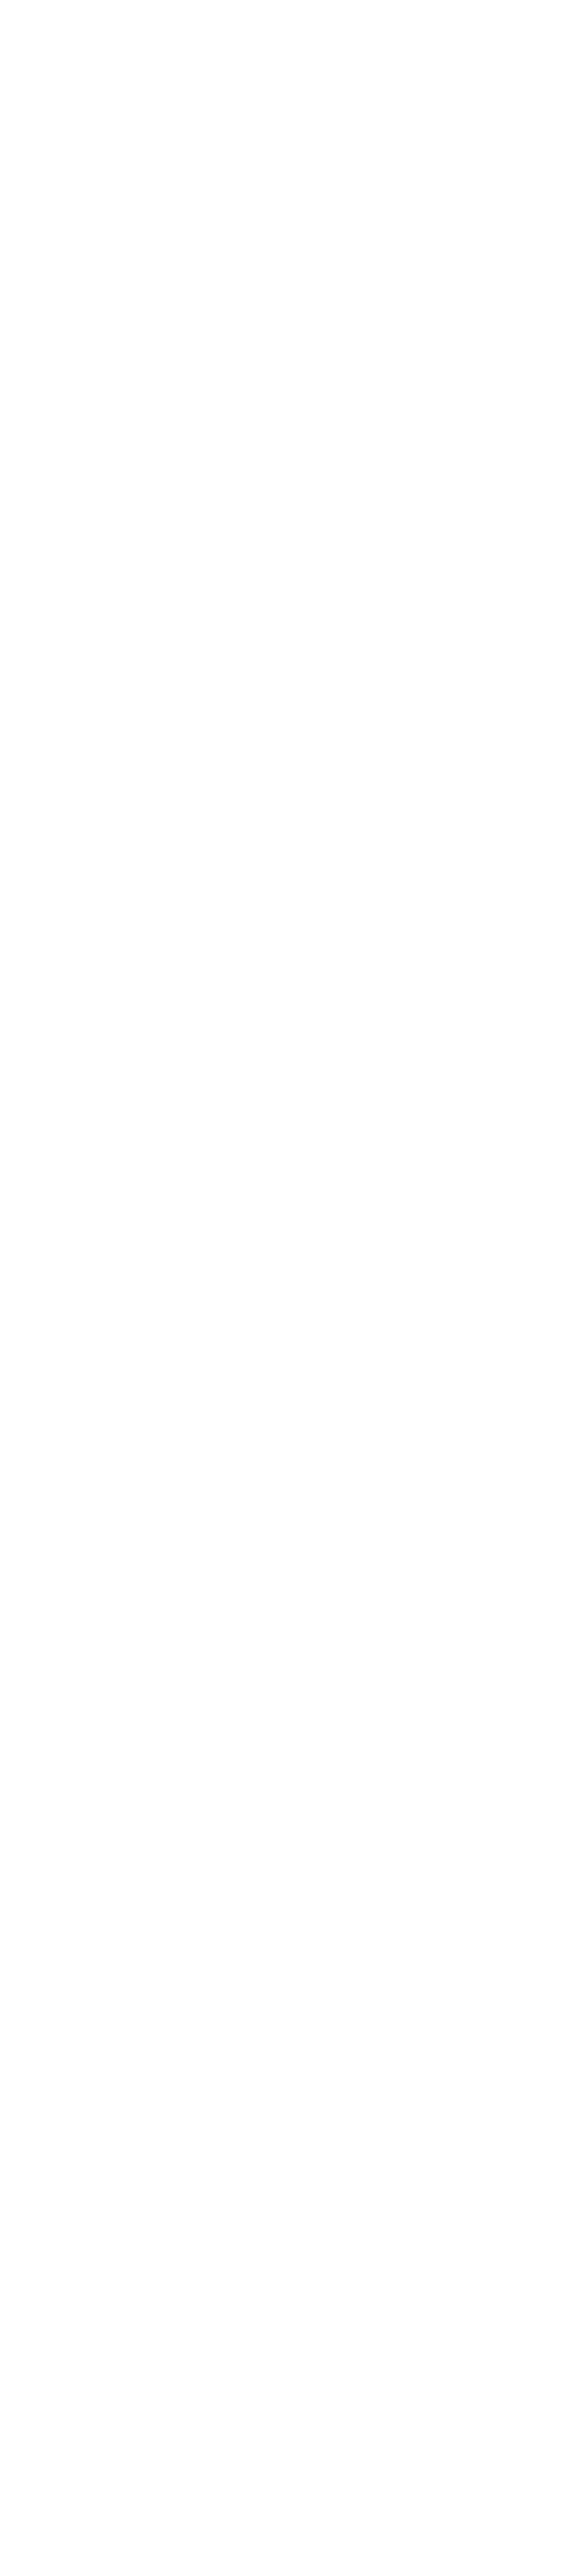

In [10]:
import matplotlib
%matplotlib nbagg

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort(ascending=True)
feature_importances.plot(kind="barh", figsize=(11,50));

### Random Forest determined lowest to most important features

In [11]:
feature_importances[:]

#feature_importances.sort_index(ascending=True)

MHSuProv3             0.000069
DrgSuPrs3             0.000097
AgChBizB3             0.000112
FamCfDV3              0.000120
SexInfrac             0.000128
STGStatus             0.000162
DrgSuFRx3             0.000192
HomConv               0.000215
AgChAnCr3             0.000239
FamHpHos3             0.000263
FamCfTPA3             0.000264
FamMCOVc3             0.000311
MHSuL6At3             0.000312
FPAHpHos3             0.000321
EmFiRPP3              0.000328
AgMoHate3             0.000334
CountVioInfracR       0.000341
FPACfTPA3             0.000359
FPACfPDV3             0.000365
AgChFrSe3             0.000372
EmBrCCI3              0.000378
AgMoHosW3             0.000429
FamCfODV3             0.000439
ResCuRTx3             0.000468
FamPrEmp3             0.000471
AtRsBost3             0.000488
EmBrHyg3              0.000512
DrgRImMH3             0.000520
MHSuOnGo3             0.000533
MHmedNC3              0.000545
                        ...   
TechVioPriorsR        0.006273
MisdDom 

### Determining top features thru the use of Kbest selection (Univariate)

In [12]:
topfeatures = SelectKBest(chi2, k=all)

In [13]:
topfeatures = SelectFpr(chi2, alpha=0.05)

### Graph showing p values from feature selection/importance model, with .05 cutoff

<IPython.core.display.Javascript object>


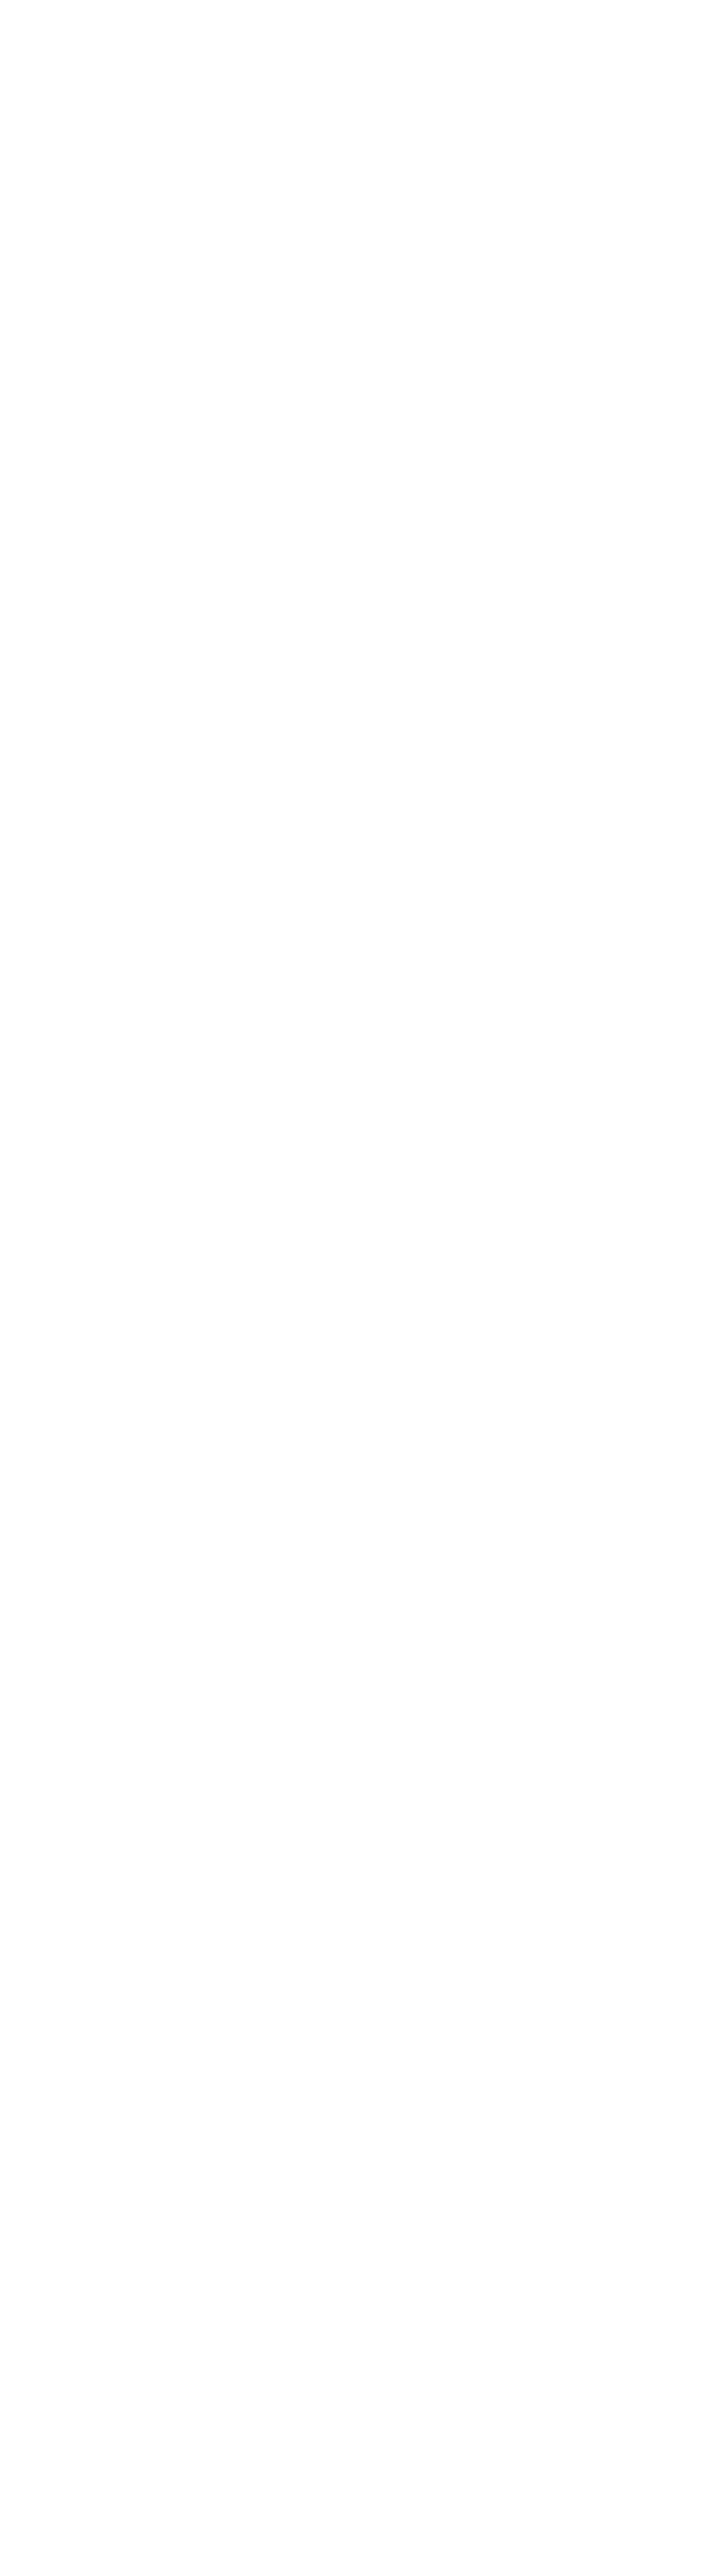

In [14]:
import matplotlib
%matplotlib nbagg

import pylab as pl

#pl.figure(1)
#pl.clf()

x_indices = np.arange(X.shape[-1])

selector = SelectFpr(f_classif, alpha=0.05)
selector.fit(X, y)
#scores = -np.log10(selector.pvalues_)
#scores /= scores.max()

tindex = pd.Series(selector.pvalues_, index=X.columns)
tindex.sort()
tindex.plot(kind="barh", figsize=(11,40));
plt.axvline(x=0.05, ymin=0, ymax = 5, linewidth=1, color='red')

#pl.bar(index, selector.pvalues_, width=1, color='red')
#plt.axhline(y=.05, xmin=0, xmax=350, linewidth=1, color = 'blue')

### Table of top 272 features, with p-values below .05

In [15]:
b = selector.pvalues_ < .05
b = pd.DataFrame(b)
b.rename(columns={0: 'sig'}, inplace=True)

Xcol = pd.DataFrame(X.columns)
bresult = pd.concat([b, Xcol], axis=1)
bresult.rename(columns={0: 'name'}, inplace=True)
bresult2 = bresult.loc[bresult['sig'] == True]

In [16]:
#bresult.loc[bresult['0'] == False]
#topfeatures = {k:v for k,v in enumerate(bresult) if v == False}
#topf = topfeatures.items()
#topfe = pd.DataFrame(topf)


In [17]:
bresult2

,sig,name
0,True,AgeAsses3RN
1,True,AgeAtFirstConvR
2,True,JvFelCon
3,True,JvVioCon
4,True,JvComit
5,True,HomConv
6,True,SexConv
7,True,VProCon
9,True,DomVio
10,True,FelWeap


In [18]:
bresult3 = bresult2["name"].tolist()

In [19]:

#feature_cols2 = ['RespOth3', 'EDQuitExpell', 'EduGdCom3N', 'FelProp', 'AgeAsses3RN', 'EmpLeng3R', 'AgeAtFirstConvR', 'FrnAnti3RC', 'TotalAdultFelonies', 'LastConviction']
#data1.drop(data1.columns["FelrecidYr3"], axis=1)
X = data1[bresult3]
#y = data1_a.FelRecidYr3.astype(int)
#y = pd.DataFrame(strongy)


## run train test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

# STEP 3 : MODEL EVALUATION - Recidivism

### MODEL 1: Comparing Test Accuracy with Null Accuracy

Null accuracy is the accuracy that could be achieved by always predicting the most frequent class. It is a benchmark against which you may want to measure your classification model.


In [21]:
# examine the class distribution
y_test.value_counts()

0    3732
1    1612
dtype: int64

In [22]:
nulltime1 = %%timeit -o 1 + 2
# calc the null accuracy
y_test.value_counts().head(1) / len(y_test)

The slowest run took 40.16 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 29.7 ns per loop


0    0.698353
dtype: float64

In [23]:
nullmodel = sklearn.dummy.DummyClassifier(strategy='most_frequent', random_state=99, constant=None)

In [24]:
nullmodel.fit(X,y)

DummyClassifier(constant=None, random_state=99, strategy='most_frequent')

In [25]:
y_pred_prob = nullmodel.predict_proba(X_test)[:, 1]

In [26]:
# calculate AUC
print metrics.roc_auc_score(y_test, y_pred_prob)

0.5


<IPython.core.display.Javascript object>


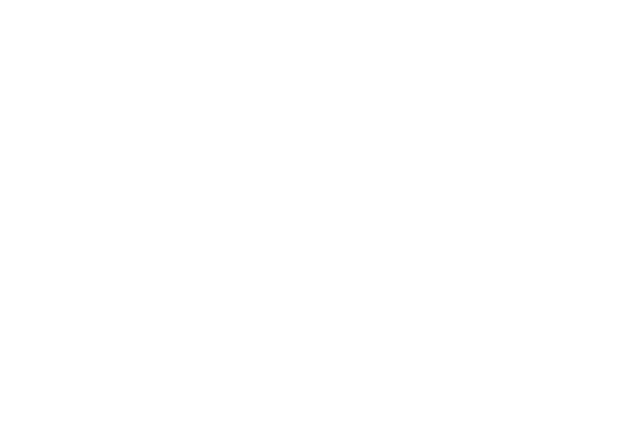

In [27]:
import matplotlib
%matplotlib nbagg
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)


In [28]:
nullmodel_mean1 = cross_val_score(nullmodel, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

In [29]:
nullmodel_scores1 = cross_val_score(nullmodel, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc')

### MODEL 2: Naive-Bayes

### MODEL 2: Naive-Bayes - Multinomial Naive Bayes

In [30]:
nbmtime1 = %%timeit -o 1 + 2
from sklearn.naive_bayes import MultinomialNB
nbm = MultinomialNB()
nbm.fit(X, y)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nbm_scores = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

#print(clf.predict(X[2:3]))

The slowest run took 433.52 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 29.7 ns per loop


In [31]:
print nbm_scores

[ 0.68521983  0.68709074  0.6777362   0.67992513  0.69302761  0.6939635
  0.70472625  0.68086102  0.70379036  0.69630323]


In [46]:
nbm_scores_mean1 = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
print nbm_scores_mean1

0.689655379209


In [47]:
nbm_scores_auc1 = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print nbm_scores_auc1

0.712768750079


In [34]:
mean_score = nbm_scores.mean()
std_dev = nbm_scores.std()
std_error = nbm_scores.std() / math.sqrt(nbm_scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Multinomial NB Score is %f +/-  %f" % (mean_score, ci)
print "Multinomial NB AUC is "
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

Multinomial NB Score is 0.690264 +/-  0.006547
Multinomial NB AUC is 
95 percent probability that if this experiment were repeated over and over the average score would be between 0.683718 and 0.696811


### MODEL 2: Naive-Bayes - Gaussian Naive Bayes

In [35]:
nbgtime1 = %%timeit -o 1 + 2
from sklearn.naive_bayes import GaussianNB
nbg = GaussianNB()
nbg.fit(X, y)
GaussianNB()
nbg_scores = cross_val_score(nbg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print nbg_scores

#print(clf.predict(X[2:3]))

10000000 loops, best of 3: 29.7 ns per loop
[ 0.68334892  0.67867166  0.68521983  0.68226486  0.68132897  0.68132897
  0.67945718  0.69021993  0.67664951  0.67898924]


In [48]:
nbg_scores_mean1 = cross_val_score(nbg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
print nbg_scores_mean1

0.680952945847


In [49]:
nbg_scores_auc1 = cross_val_score(nbg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print nbg_scores_auc1

0.675158737479


### MODEL 2: Naive-Bayes - Bernoulli Naive Bayes

In [39]:
nbbtime1 = %%timeit -o 1 + 2
from sklearn.naive_bayes import BernoulliNB
nbb = BernoulliNB()
nbb.fit(X, y)
BernoulliNB(alpha=1.0, class_prior=None, fit_prior=True)
nbb_scores = cross_val_score(nbb, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print nbb_scores

#print(clf.predict(X[2:3]))

The slowest run took 36.38 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 35.4 ns per loop
[ 0.65762395  0.64078578  0.66651076  0.65980346  0.67337389  0.66167525
  0.66916238  0.68741226  0.68039307  0.65886757]


In [50]:
nbb_scores_mean1 = cross_val_score(nbb, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
print nbb_scores_mean1

0.665698812801


In [51]:
nbb_scores_auc1 = cross_val_score(nbb, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print nbb_scores_auc1

0.708537484107


### MODEL 2: Naive-Bayes - Best performing Naive Bayes??

<IPython.core.display.Javascript object>


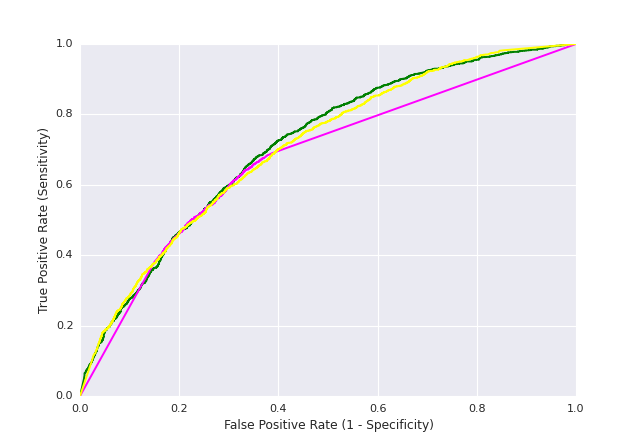

In [42]:
# TASK 7: plot the ROC curve
import matplotlib
%matplotlib nbagg
from sklearn import metrics
import pandas as pd
from ggplot import *


nbm_preds = nbm.predict_proba(X_test)[:,1]
nbm_fpr, nbm_tpr, _ = metrics.roc_curve(y_test, nbm_preds)

nbg_preds = nbg.predict_proba(X_test)[:,1]
nbg_fpr, nbg_tpr, _ = metrics.roc_curve(y_test, nbg_preds)

nbb_preds = nbb.predict_proba(X_test)[:,1]
nbb_fpr, nbb_tpr, _ = metrics.roc_curve(y_test, nbb_preds)

plt.plot(nbm_fpr, nbm_tpr, color='green')
plt.plot(nbg_fpr, nbg_tpr, color='magenta')
plt.plot(nbb_fpr, nbb_tpr, color='yellow')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')


### Multinomial NB was the best performing NB with an AUC of 68%.  (green ROC above)

### MODEL3: KNN

In [43]:
knn = KNeighborsClassifier(n_neighbors=9)
#strongy = data1.FelRecidYr3
knn.fit(X,y)
knn_scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

In [44]:
print knn_scores

[ 0.70954163  0.73199252  0.70159027  0.71595695  0.70238652  0.7103416
  0.70379036  0.71221338  0.70425831  0.70706598]


In [52]:
# use average accuracy as an estimate of out-of-sample accuracy
knn_scores_mean1 = knn_scores.mean()
print knn_scores_mean1

0.709913751782


In [ ]:
knn_scores_auc = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print knn_scores_auc

In [63]:
# search for an optimal value of K for KNN
k_range = range(1, 100)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    k_scores.append(knn_scores.mean())
print k_scores

KeyboardInterrupt: 

In [ ]:
import matplotlib
%matplotlib nbagg

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

### MODEL3: KNN - Re-run KNN model with optimized K = 40

In [ ]:
knntime1 = %%timeit -o 1 + 2
knn = KNeighborsClassifier(n_neighbors=40)
#strongy = data1.FelRecidYr3
knn_scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print knn_scores

In [ ]:
import math
mean_score = knn_scores.mean()
std_dev = knn_scores.std()
std_error = knn_scores.std() / math.sqrt(scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Score is %f +/-  %f" % (mean_score, ci)
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

In [ ]:
# use average accuracy as an estimate of out-of-sample accuracy
knn_mean1 = knn_scores.mean()

In [ ]:
knn_scores_auc = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print knn_scores_auc

### MODEL 4: Logistic Regression

#### MODEL 4: Logistic Regression - 10-fold cross-validation with logistic regression

In [ ]:
logregtime1 = %%timeit -o 1 + 2
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X,y)
logreg_scores = cross_val_score(logreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')


#### MODEL 4: Logistic Regression - Print Logistic Regression cross validation accuracy scores

print logreg_scores

#### MODEL 4: Logistic Regression - Print Logistic Regression cross validation accuracy score - mean

In [ ]:
logreg_mean1 = cross_val_score(logreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

#### MODEL 4: Logistic Regression - Print Logistic Regression cross validation auc score - mean

In [ ]:
logreg_auc_scores = cross_val_score(logreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()

In [ ]:
print logreg_auc_scores.mean()

In [ ]:
mean_score = logreg_scores.mean()
std_dev = logreg_scores.std()
std_error = logreg_scores.std() / math.sqrt(logreg_scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Score is %f +/-  %f" % (mean_score, ci)
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

### MODEL 5: SVM Polynomial Kernel

#### MODEL 5: SVM Polynomial Kernel - 10-fold cross-validation with SVM Poly

In [ ]:
# 10-fold cross-validation with SVM Polynomial
from sklearn import svm
svmpoly = svm.SVC(kernel='poly', gamma=2)
svmpoly.fit(X,y)
svmpoly_scores = cross_val_score(svmpoly, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print svmpoly_scores

#### MODEL 5: SVM Polynomial Kernel - Search for an optimal gamma/depth for SVM Polynomial

In [ ]:
# search for an optimal gamma for SVM Polynomial
g_range = range(1, 10)
g_scores = []
for k in g_range:
    knn = svm.SVC(kernel='poly', gamma=k)
    scores = cross_val_score(svmpoly, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    g_scores.append(scores.mean())
print g_scores

#### MODEL 5: SVM Polynomial Kernel - Tune SVM Hyperparameters - C and gamma

In [ ]:

import optunity
import optunity.metrics
import sklearn.svm

# score function: twice iterated 10-fold cross-validated accuracy
@optunity.cross_validated(x=data1[feature_cols2], y=data1.FelRecidYr3, num_folds=10, num_iter=2)
def svm_auc(x_train, y_train, x_test, y_test, logC, logGamma):
    model = sklearn.svm.SVC(C=10 ** logC, gamma=10 ** logGamma).fit(x_train, y_train)
    decision_values = model.decision_function(x_test)
    return optunity.metrics.roc_auc(y_test, decision_values)

# perform tuning
hps, _, _ = optunity.maximize(svm_auc, num_evals=200, logC=[-5, 2], logGamma=[-5, 1])


In [ ]:
svmpolytime1 = %%timeit -o 1 + 2
# train model on the full training set with tuned hyperparameters
optimal_model = sklearn.svm.SVC(C=10 ** hps['logC'], gamma=10 ** hps['logGamma']).fit(X, y)


In [ ]:
svmpoly_mean1 = cross_val_score(optimal_model, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

#### MODEL 5: SVM Polynomial Kernel - Plotting SVM boundaries

In [ ]:
fignum=1

# plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(4, 3))
    plt.svmpoly()

    plt.scatter(svmpoly.support_vectors_[:, 0], svmpoly.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10)
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired)

    plt.axis('tight')
    x_min = -3
    x_max = 3
    y_min = -3
    y_max = 3

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = svmpoly.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(4, 3))
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1
plt.show()

### MODEL 5: SVM Gaussian Kernel

In [ ]:

# 10-fold cross-validation with SVM Gaussian
from sklearn import svm
svmrbf = svm.SVC(kernel='rbf', gamma=2)
svmrbf.fit(X,y)
svmrbf_scores = cross_val_score(svmrbf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print svmrbf_scores

In [ ]:
# search for an optimal gamma for SVM Polynomial
g_range = range(1, 10)
g_scores = []
for k in g_range:
    knn = svm.SVC(kernel='poly', gamma=k)
    scores = cross_val_score(svmpoly, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    g_scores.append(scores.mean())
print g_scores

In [ ]:
import optunity
import optunity.metrics
import sklearn.svm

# score function: twice iterated 10-fold cross-validated accuracy
@optunity.cross_validated(x=data1[feature_cols2], y=data1.FelRecidYr3, num_folds=10, num_iter=2)
def svm_auc(x_train, y_train, x_test, y_test, logC, logGamma):
    model = sklearn.svm.SVC(C=10 ** logC, gamma=10 ** logGamma).fit(x_train, y_train)
    decision_values = model.decision_function(x_test)
    return optunity.metrics.roc_auc(y_test, decision_values)

# perform tuning
hps, _, _ = optunity.maximize(svm_auc, num_evals=200, logC=[-5, 2], logGamma=[-5, 1])



In [ ]:
svmgaustime1 = %%timeit -o 1 + 2
# train model on the full training set with tuned hyperparameters
optimal_model = sklearn.svm.SVC(C=10 ** hps['logC'], gamma=10 ** hps['logGamma']).fit(X, y)

In [ ]:
svmgaus_mean1 = cross_val_score(optimal_model, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

In [ ]:
fignum=1

# plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(4, 3))
    plt.svmpoly()

    plt.scatter(svmpoly.support_vectors_[:, 0], svmpoly.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10)
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired)

    plt.axis('tight')
    x_min = -3
    x_max = 3
    y_min = -3
    y_max = 3

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = svmpoly.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(4, 3))
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1
plt.show()

### MODEL 6: Decision Tree

#### MODEL 6: Decision Tree - Initial Decision Tree with max depth of 10

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=10)
clf.fit(X,y)
clf_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

#### MODEL 6: Decision Tree - Print Decision Tree cross validation accuracy scores

In [ ]:
print clf_scores

#### MODEL 6: Decision Tree -  Print Decision Tree cross validation accuracy score - mean

In [ ]:
clf_scores_mean1 = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
print clf_scores_mean1

#### MODEL 6: Decision Tree - Print Decision Tree cross validation auc score - mean

In [ ]:
clf_scores_auc = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print clf_scores_auc

#### MODEL 6: Decision Tree - Save and print graphic of Decision Tree

In [ ]:
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 

In [ ]:
graph.write_jpeg("hw3_tree_plot.jpg")

In [ ]:
from IPython.display import Image
Image(filename='hw3_tree_plot.jpg')

### MODEL 6: Decision Tree - search for an optimal gamma/depth for Decision Tree

In [ ]:
t_range = range(1, 100)
t_scores = []
for k in t_range:
    clf = tree.DecisionTreeClassifier(max_depth=k)
    scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    t_scores.append(scores.mean())
print t_scores

### MODEL 6: Decision Tree - Plot accuracy of cross validation runs vs. values of depth

In [ ]:
import matplotlib
%matplotlib nbagg
plt.plot(t_range, t_scores)
plt.xlabel('Value of Depth for Decision Tree')
plt.ylabel('Cross-Validated Accuracy')

### MODEL 6: Decision Tree - Model optimization results:

After examining accuracy for a variety of depths, its appears that a value of ~45 for a max depth is optimal in terms of cross validation accuracy.

In [ ]:
estimator_range = range(1, 100)

from sklearn import tree

RMSE_scores = []

for estimator in estimator_range:
    clf = tree.DecisionTreeClassifier(max_depth=estimator)
    clf.fit(X,y)
    MSE_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

### MODEL 6: Decision Tree - Plot N Estimators vs. RMSE

In [ ]:
import matplotlib
%matplotlib nbagg

# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

### MODEL 6: Decision Tree - Re-run Decision Tree model with optimized Depth = 45

In [ ]:
clftime1 = %%timeit -o 1 + 2
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=10)
clf.fit(X,y)
clf_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

In [ ]:
print clf_scores

In [ ]:
clf_mean1 = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

### MODEL 7: Bootstrap Aggregation using Decision Tree

In [ ]:
bag_scores = []

bag_range = range(1, 100)

for k in bag_range:
    bag_clf = BaggingClassifier(clf, n_estimators=k, max_samples=1.0, max_features=5, bootstrap = False, bootstrap_features = True, random_state=42)
    bag_clf.fit(X, y)
    bag_clf_scores = cross_val_score(bag_clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    MSE_scores = cross_val_score(bag_clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='mean_squared_error')
    bag_scores.append(bag_clf_scores.mean())
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
print bag_clf_scores

In [ ]:
import matplotlib
%matplotlib nbagg
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(bag_range, bag_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

### MODEL 8: Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf.fit(X, y)
rf_scores = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
rf_auc_scores = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc')

In [ ]:
print rf_scores

In [ ]:
print rf_scores.mean()

In [ ]:
rf.oob_score_

In [ ]:
#y_oob = rf.oob_prediction_
#print "c-stat: ", roc_auc_score(y, y_oob)

### MODEL 8: Random Forest - Find optimal number of leaves

In [ ]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
for min_samples in min_samples_leaf_options:
    rf = RandomForestClassifier(n_estimators=100, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features="auto", 
                                  min_samples_leaf=min_samples)
    rf.fit(X, y)
    print min_samples, "min samples"
    roc = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
    print "C-stat: ", roc
    results.append(roc)
    print ""

In [ ]:
import matplotlib
%matplotlib nbagg

pd.Series(results, min_samples_leaf_options).plot();

### MODEL 8: Random Forest - Determine optimal depth for Random Forest

In [ ]:
t_range = range(1, 100)
t_scores = []
results = []
RMSE_scores = []
for k in t_range:
    clf = RandomForestClassifier(max_depth=k)
    scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    clf_auc_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc')
    MSE_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='mean_squared_error')
    t_scores.append(scores.mean())
    results.append(clf_auc_scores)
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
print t_scores

In [ ]:
import matplotlib
%matplotlib nbagg
plt.plot(t_range, RMSE_scores)
plt.xlabel('Max Depth')
plt.ylabel('RMSE - Lower is better')

In [ ]:
import matplotlib
%matplotlib nbagg
plt.plot(t_range, t_scores)
plt.xlabel('Max Depth')
plt.ylabel('Cross Validated Accuracy')

In [ ]:
import matplotlib
%matplotlib nbagg
plt.plot(t_range, results)
plt.xlabel('Max Depth')
plt.ylabel('RMSE - Lower is better')

### MODEL 8: Random Forest - Search for an optimal number of estimators

In [ ]:
k_range = range(1, 100)
k_scores = []
for k in k_range:
    rf = RandomForestClassifier(n_estimators=k, oob_score=True, random_state=42)
    rf_scores = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    k_scores.append(rf_scores.mean())
print k_scores

### MODEL 8: Random Forest - Plot number of estimators with cross-validated accuracy

In [ ]:
import matplotlib
%matplotlib nbagg
plt.plot(k_range, k_scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validated Accuracy')

### MODEL 8: Random Forest - optimize for max number of features

In [ ]:
import matplotlib
%matplotlib nbagg

results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestClassifier(n_estimators=10, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X, y)
    roc = cross_val_score(model, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
    print max_features, "option"
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, max_features_options).plot(kind="barh", xlim=(.60,.65));

### MODEL 8: Re-Run Random Forest after optimization of all hyperparameters

In [ ]:
rftime1 = %%timeit -o 1 + 2
rf = RandomForestClassifier(n_estimators=60, max_features=.2, max_depth=50,  oob_score=True, min_samples_leaf=10, random_state=42)
rf.fit(X, y)
rf_scores = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

In [ ]:
rf_mean1 = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

## MODEL 9: Bagged Random Forest (using optimized parameters from above)

In [ ]:
rfbag_scores = []

rfbag_range = range(1, 100)
rfRMSE_scores = []

for k in bag_range:
    rfbag_clf = RandomForestClassifier(n_estimators=60, max_features=.2, max_depth=50,  oob_score=True, min_samples_leaf=10, random_state=42)
    rfbag_clf.fit(X, y)
    rfbag_clf_scores = cross_val_score(rfbag_clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    rfMSE_scores = cross_val_score(rfbag_clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='mean_squared_error')
    rfbag_scores.append(rfbag_clf_scores.mean())
    rfRMSE_scores.append(np.mean(np.sqrt(-rfMSE_scores)))
print rfbag_clf_scores

In [ ]:
import matplotlib
%matplotlib nbagg
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(rfbag_range, rfbag_scores)
plt.xlabel('N estimators')
plt.ylabel('RMSE (lower is better)')

## MODEL 9: Bagged Random Forest - optimized

## MODEL 10:  NOISY REPLICATION

## MODEL 11:  new classifier

# DATA2 - MUSIC

# STEP 1: DATA LOADING - Music

In [ ]:
urllib.urlretrieve('http://www.webpages.uidaho.edu/erichs/music.json', '/git/data/hw3/music.json')

In [ ]:
with open('/git/data/hw3/music.json', 'rU') as f:
    data = [json.loads(row) for row in f]
    data2 = pd.DataFrame(data)

## What variables are appropriate to be used as features?

In [ ]:
data2[:1]

#### Comment: from the fields above, 'helpful', 'overall', 'reviewText', 'unixReviewTime' are useful fields.  

FEATURE VARIABLES:

Helpfulness index - helpful index - represents a ratio - numerator is the number of people who rated this review
positively, with the denominator representing the total number of people who rated this review.

reviewText - main text of the review

Summary - a summary sentence of the review, provided by the reviewer.


RESPONSE VARIABLES:

Overall - overall ranking of review

# STEP 2: FEATURE SELECTION - Music

## Converting helpfulness rating into a percentage

In [ ]:
helpfulness_ratio = data2.helpful.tolist()
helpfulness_ratio_final = pd.DataFrame(helpfulness_ratio)

In [ ]:
helpfulness_ratio_final['helpfulness_ratio'] = helpfulness_ratio_final[0] / helpfulness_ratio_final[1]

## Preparing X and y: adding helpfulness ratio as a column, eliminating rows where helpfulness ratio is NAN.

In [ ]:
data2 = pd.DataFrame(data)
data2 = pd.concat([data2, helpfulness_ratio_final], axis=1)
feature_cols = ['helpfulness_ratio', 'reviewText', 'unixReviewTime', 'summary', 'overall']
#feature_cols = ['reviewText']
# removing data that is not a review of 5 or 1 
music_best_worst = data2[(data2.overall==5) | (data2.overall==1)]
# removing rows that have NAN values for helpfulness (0/0)
music_best_worst = music_best_worst[np.isfinite(music_best_worst['helpfulness_ratio'])]
# group feature columns together for X
music_best_worst_featureadd = music_best_worst[feature_cols] #for use in Task 6

#--Setting X and y for music
#X = music_best_worst_featureadd
y = music_best_worst_featureadd.overall


In [ ]:
y.shape

## Vectorizing Reviewtext

In [ ]:
data2["score"] = np.nan

In [ ]:
import scipy as sp
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2), max_features=1000)
#y = data2["score"].values.astype(np.float32) 

X = sp.sparse.hstack((vectorizer.fit_transform(music_best_worst_featureadd.reviewText),music_best_worst_featureadd[['helpfulness_ratio','unixReviewTime']].values),format='csr')
X_columns=vectorizer.get_feature_names()+music_best_worst_featureadd[['helpfulness_ratio','unixReviewTime']].columns.tolist()


In [ ]:
#X_reviewtext= sp.issparse(X_reviewtext)

## Create test train split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

### Linear Regression - 10-fold cross-validation with all three features

In [ ]:
lm = LinearRegression()
scores = cross_val_score(lm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='mean_squared_error')
print scores

In [ ]:
# fix the sign of MSE scores
mse_scores = -scores
print mse_scores

In [ ]:
# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)
print rmse_scores

In [ ]:
# calculate the average RMSE
print rmse_scores.mean()

# STEP 3 : MODEL EVALUATION - Music

### MODEL 1: Comparing Test Accuracy with Null Accuracy

Null accuracy is the accuracy that could be achieved by always predicting the most frequent class. It is a benchmark against which you may want to measure your classification model.

In [ ]:
# examine the class distribution
y_test.value_counts()

In [ ]:
nulltime2 = %%timeit -o 1 + 2
# calculate the null accuracy
y_test.value_counts().head(1) / len(y_test)

In [ ]:
nullmodel2 = sklearn.dummy.DummyClassifier(strategy='most_frequent', random_state=99, constant=None)

In [ ]:
y_pred_prob = nullmodel2.predict_proba(X_test)[:, 1]

In [ ]:
# calculate AUC
print metrics.roc_auc_score(y_test, y_pred_prob)

In [ ]:
nullmodel2.fit(X,y)

In [ ]:
# histogram of predicted probabilities grouped by actual response value
df = pd.DataFrame({'probability':y_pred_prob, 'actual':y_test})
df.hist(column='probability', by='actual', sharex=True, sharey=True)

In [ ]:
import matplotlib
%matplotlib nbagg
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)

In [ ]:

nullmodel2_scores = cross_val_score(nullmodel2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc')

### MODEL 2: Naive-Bayes

### MODEL 2: Naive-Bayes - Multinomial Naive Bayes

In [ ]:

nbmtime2 = %%timeit -o 1 + 2
from sklearn.naive_bayes import MultinomialNB
nbm2 = MultinomialNB()
nbm2.fit(X, y)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nbm2_scores = cross_val_score(nbm2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

#print(clf.predict(X[2:3]))

In [ ]:
print nbm2_scores

In [ ]:
nbm2_scores_mean = cross_val_score(nbm2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
print nbm2_scores_mean

In [ ]:
nbm2_scores_auc = cross_val_score(nbm2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print nbm2_scores_auc

In [ ]:
mean_score = nbm2_scores.mean()
std_dev = nbm2_scores.std()
std_error = nbm2_scores.std() / math.sqrt(nbm2_scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Multinomial NB Score is %f +/-  %f" % (mean_score, ci)
print "Multinomial NB AUC is "
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

### MODEL 2: Naive-Bayes - Gaussian Naive Bayes

In [ ]:
nbgtime2 = %%timeit -o 1 + 2
from sklearn.naive_bayes import GaussianNB
nbg2 = GaussianNB()
nbg2.fit(X, y)
GaussianNB()
nbg2_scores = cross_val_score(nbg2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print nbg2_scores

#print(clf.predict(X[2:3]))

In [ ]:
nbg2_scores_mean = cross_val_score(nbg2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
print nbg2_scores_mean

In [ ]:
nbg2_scores_auc = cross_val_score(nbg2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print nbg2_scores_auc

### MODEL 2: Naive-Bayes - Bernoulli Naive Bayes

In [ ]:
nbbtime2 = %%timeit -o 1 + 2
from sklearn.naive_bayes import BernoulliNB
nbb2 = BernoulliNB()
nbb2.fit(X, y)
BernoulliNB(alpha=1.0, class_prior=None, fit_prior=True)
nbb2_scores = cross_val_score(nbb2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print nbb_scores

#print(clf.predict(X[2:3]))

In [ ]:
nbb2_scores_mean = cross_val_score(nbb2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
print nbb2_scores_mean

In [ ]:
nbb2_scores_auc = cross_val_score(nbb2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print nbb2_scores_auc

### MODEL 2: Naive-Bayes - Best performing Naive Bayes??

In [ ]:
# TASK 7: plot the ROC curve
import matplotlib
%matplotlib nbagg
from sklearn import metrics
import pandas as pd
from ggplot import *


nbm2_preds = nbm2.predict_proba(X_test)[:,1]
nbm2_fpr, nbm2_tpr, _ = metrics.roc_curve(y_test, nbm2_preds)

nbg2_preds = nbg2.predict_proba(X_test)[:,1]
nbg2_fpr, nbg2_tpr, _ = metrics.roc_curve(y_test, nbg2_preds)

nbb2_preds = nbb2.predict_proba(X_test)[:,1]
nbb2_fpr, nbb2_tpr, _ = metrics.roc_curve(y_test, nbb2_preds)

plt.plot(nbm2_fpr, nbm2_tpr, color='green')
plt.plot(nbg2_fpr, nbg2_tpr, color='magenta')
plt.plot(nbb2_fpr, nbb2_tpr, color='yellow')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')


### MODEL3: KNN

In [ ]:
knn2 = KNeighborsClassifier(n_neighbors=9)
#strongy = data1.FelRecidYr3
knn2.fit(X,y)
knn2_scores = cross_val_score(knn2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print knn2_scores

In [ ]:
# use average accuracy as an estimate of out-of-sample accuracy
print knn2_scores.mean()


In [ ]:
# search for an optimal value of K for KNN
k2_range = range(1, 100)
k2_scores = []
for k in k2_range:
    knn2 = KNeighborsClassifier(n_neighbors=k)
    knn2_scores = cross_val_score(knn2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    k_scores.append(knn2_scores.mean())
print k2_scores

In [ ]:
import matplotlib
%matplotlib nbagg

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

### MODEL3: KNN - Re-run KNN model with optimized K = 40

In [ ]:
knntime2 = %%timeit -o 1 + 2
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn2 = KNeighborsClassifier(n_neighbors=40)
#strongy = data1.FelRecidYr3
knn2_scores = cross_val_score(knn2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print knn2_scores

In [ ]:
knn_mean2 = cross_val_score(knn2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

In [ ]:
import math
mean_score = knn2_scores.mean()
std_dev = knn2_scores.std()
std_error = knn2_scores.std() / math.sqrt(scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Score is %f +/-  %f" % (mean_score, ci)
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

### MODEL 4: Logistic Regression

#### MODEL 4: Logistic Regression - 10-fold cross-validation with logistic regression

In [ ]:
logregtime2 = %%timeit -o 1 + 2
from sklearn.linear_model import LogisticRegression
logreg2 = LogisticRegression()
logreg2.fit(X,y)
logreg2_scores = cross_val_score(logreg2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

In [ ]:
logreg2_auc_scores = cross_val_score(logreg2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc')

#### MODEL 4: Logistic Regression - Print Logistic Regression cross validation accuracy scores

print logreg_scores

#### MODEL 4: Logistic Regression - Print Logistic Regression cross validation accuracy score - mean

In [ ]:
logreg_mean2 = cross_val_score(logreg2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

#### MODEL 4: Logistic Regression - Print Logistic Regression cross validation auc score - mean

In [ ]:
print logreg2_auc_scores.mean()

In [ ]:
mean_score = logreg2_scores.mean()
std_dev = logreg2_scores.std()
std_error = logreg2_scores.std() / math.sqrt(logreg_scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Score is %f +/-  %f" % (mean_score, ci)
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

### MODEL 5: SVM Polynomial Kernel

#### MODEL 5: SVM Polynomial Kernel - 10-fold cross-validation with SVM Poly

In [ ]:
# 10-fold cross-validation with SVM Polynomial
from sklearn import svm
svmpoly2 = svm.SVC(kernel='poly', gamma=2)
svmpoly2.fit(X,y)
svmpoly2_scores = cross_val_score(svmpoly2, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print svmpoly2_scores

#### MODEL 5: SVM Polynomial Kernel - Search for an optimal gamma/depth for SVM Polynomial

In [ ]:
# search for an optimal gamma for SVM Polynomial
g_range = range(1, 10)
g_scores = []
for k in g_range:
    knn = svm.SVC(kernel='poly', gamma=k)
    scores = cross_val_score(svmpoly, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    g_scores.append(scores.mean())
print g_scores

#### MODEL 5: SVM Polynomial Kernel - Tune SVM Hyperparameters - C and gamma

In [ ]:
svmpolytime2 = %%timeit -o 1 + 2
import optunity
import optunity.metrics
import sklearn.svm

# score function: twice iterated 10-fold cross-validated accuracy
@optunity.cross_validated(x=data1[feature_cols2], y=data1.FelRecidYr3, num_folds=10, num_iter=2)
def svm_auc(x_train, y_train, x_test, y_test, logC, logGamma):
    model = sklearn.svm.SVC(C=10 ** logC, gamma=10 ** logGamma).fit(x_train, y_train)
    decision_values = model.decision_function(x_test)
    return optunity.metrics.roc_auc(y_test, decision_values)

# perform tuning
hps, _, _ = optunity.maximize(svm_auc, num_evals=200, logC=[-5, 2], logGamma=[-5, 1])

In [ ]:
# train model on the full training set with tuned hyperparameters

optimal_model = sklearn.svm.SVC(C=10 ** hps['logC'], gamma=10 ** hps['logGamma']).fit(X, y)
svmpoly_mean2 = cross_val_score(optimal_model, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()


#### MODEL 5: SVM Polynomial Kernel - Plotting SVM boundaries

In [ ]:
fignum=1

# plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(4, 3))
    plt.svmpoly()

    plt.scatter(svmpoly.support_vectors_[:, 0], svmpoly.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10)
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired)

    plt.axis('tight')
    x_min = -3
    x_max = 3
    y_min = -3
    y_max = 3

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = svmpoly.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(4, 3))
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1
plt.show()

### MODEL 5: SVM Gaussian Kernel

In [ ]:

# 10-fold cross-validation with SVM Polynomial
from sklearn import svm
svmrbf = svm.SVC(kernel='rbf', gamma=2)
svmrbf.fit(X,y)
svmpoly2_scores = cross_val_score(svmpoly, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print svmpoly_scores


In [ ]:
# search for an optimal gamma for SVM Polynomial
g_range = range(1, 10)
g_scores = []
for k in g_range:
    knn = svm.SVC(kernel='rbf', gamma=k)
    scores = cross_val_score(svmpoly, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    g_scores.append(scores.mean())
print g_scores

In [ ]:
svmgaustime2 = %%timeit -o 1 + 2

import optunity
import optunity.metrics
import sklearn.svm

# score function: twice iterated 10-fold cross-validated accuracy
@optunity.cross_validated(x=data1[feature_cols2], y=data1.FelRecidYr3, num_folds=10, num_iter=2)

def svm_auc(x_train, y_train, x_test, y_test, logC, logGamma):
    model = sklearn.svm.SVC(C=10 ** logC, gamma=10 ** logGamma).fit(x_train, y_train)
    decision_values = model.decision_function(x_test)
    return optunity.metrics.roc_auc(y_test, decision_values)

# perform tuning
hps, _, _ = optunity.maximize(svm_auc, num_evals=200, logC=[-5, 2], logGamma=[-5, 1])



In [ ]:
# train model on the full training set with tuned hyperparameters
optimal_model = sklearn.svm.SVC(C=10 ** hps['logC'], gamma=10 ** hps['logGamma']).fit(X, y)
svmgaus_mean2 = cross_val_score(optimal_model, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

In [ ]:
fignum=1

# plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(4, 3))
    plt.svmpoly()

    plt.scatter(svmpoly.support_vectors_[:, 0], svmpoly.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10)
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired)

    plt.axis('tight')
    x_min = -3
    x_max = 3
    y_min = -3
    y_max = 3

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = svmpoly.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(4, 3))
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1
plt.show()

### MODEL 6: Decision Tree

#### MODEL 6: Decision Tree - Initial Decision Tree with max depth of 10

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=10)
clf.fit(X,y)
clf_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

#### MODEL 6: Decision Tree - Print Decision Tree cross validation accuracy scores

In [ ]:
print clf_scores

#### MODEL 6: Decision Tree -  Print Decision Tree cross validation accuracy score - mean

In [ ]:
clf_scores_mean = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
print clf_scores_mean

#### MODEL 6: Decision Tree - Print Decision Tree cross validation auc score - mean

In [ ]:
clf_scores_auc = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print clf_scores_auc

#### MODEL 6: Decision Tree - Save and print graphic of Decision Tree

In [ ]:
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 

In [ ]:
graph.write_jpeg("hw3_tree_plot.jpg")

In [ ]:
from IPython.display import Image
Image(filename='hw3_tree_plot.jpg')

### MODEL 6: Decision Tree - search for an optimal gamma/depth for Decision Tree

In [ ]:
t_range = range(1, 100)
t_scores = []
for k in t_range:
    clf = tree.DecisionTreeClassifier(max_depth=k)
    scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    t_scores.append(scores.mean())
print t_scores

### MODEL 6: Decision Tree - Plot accuracy of cross validation runs vs. values of depth

In [ ]:
import matplotlib
%matplotlib nbagg
plt.plot(t_range, t_scores)
plt.xlabel('Value of Depth for Decision Tree')
plt.ylabel('Cross-Validated Accuracy')

### MODEL 6: Decision Tree - Model optimization results:

After examining accuracy for a variety of depths, its appears that a value of ~45 for a max depth is optimal in terms of cross validation accuracy.

### MODEL 6: Decision Tree - Plot N Estimators vs. RMSE

In [ ]:
estimator_range = range(1, 100)

from sklearn import tree

RMSE_scores = []

for estimator in estimator_range:
    clf = tree.DecisionTreeClassifier(max_depth=estimator)
    clf.fit(X,y)
    MSE_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [ ]:
import matplotlib
%matplotlib nbagg

# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

### MODEL 6: Decision Tree - Re-run Decision Tree model with optimized Depth = 45

In [ ]:
clftime2 = %%timeit -o 1 + 2
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=45)
clf.fit(X,y)
clf_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

In [ ]:
clf_mean2 = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

### MODEL 7: Bootstrap Aggregation using Decision Tree

In [ ]:
bag_scores = []

bag_range = range(1, 100)

for k in bag_range:
    bag_clf = BaggingClassifier(clf, n_estimators=k, max_samples=1.0, max_features=5, bootstrap = False, bootstrap_features = True, random_state=42)
    bag_clf.fit(X, y)
    bag_clf_scores = cross_val_score(bag_clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    MSE_scores = cross_val_score(bag_clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='mean_squared_error')
    bag_scores.append(bag_clf_scores.mean())
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
print bag_clf_scores

In [ ]:
import matplotlib
%matplotlib nbagg
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(bag_range, bag_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

### MODEL 8: Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf.fit(X, y)
rf_scores = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

In [ ]:
rf_auc_scores = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc')

In [ ]:
print rf_scores

In [ ]:
print rf_scores.mean()

In [ ]:
rf.oob_score_

### MODEL 8: Random Forest - Find optimal number of leaves

In [ ]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
for min_samples in min_samples_leaf_options:
    rf = RandomForestClassifier(n_estimators=100, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features="auto", 
                                  min_samples_leaf=min_samples)
    rf.fit(X, y)
    print min_samples, "min samples"
    roc = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
    print "C-stat: ", roc
    results.append(roc)
    print ""

In [ ]:
import matplotlib
%matplotlib nbagg

pd.Series(results, min_samples_leaf_options).plot();

### MODEL 8: Random Forest - Determine optimal depth for Random Forest

In [ ]:
t_range = range(1, 100)
t_scores = []
results = []
RMSE_scores = []
for k in t_range:
    clf = RandomForestClassifier(max_depth=k)
    scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    clf_auc_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc')
    MSE_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='mean_squared_error')
    t_scores.append(scores.mean())
    results.append(clf_auc_scores)
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
print t_scores

In [ ]:
import matplotlib
%matplotlib nbagg
plt.plot(t_range, RMSE_scores)
plt.xlabel('Max Depth')
plt.ylabel('RMSE - Lower is better')

In [ ]:
import matplotlib
%matplotlib nbagg
plt.plot(t_range, t_scores)
plt.xlabel('Max Depth')
plt.ylabel('Cross Validated Accuracy')

In [ ]:
import matplotlib
%matplotlib nbagg
plt.plot(t_range, results)
plt.xlabel('Max Depth')
plt.ylabel('RMSE - Lower is better')

### MODEL 8: Random Forest - Search for an optimal number of estimators

In [ ]:
k_range = range(1, 100)
k_scores = []
for k in k_range:
    rf = RandomForestClassifier(n_estimators=k, oob_score=True, random_state=42)
    rf_scores = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    k_scores.append(rf_scores.mean())
print k_scores

### MODEL 8: Random Forest - Plot number of estimators with cross-validated accuracy

In [ ]:
import matplotlib
%matplotlib nbagg
plt.plot(k_range, k_scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validated Accuracy')

### MODEL 8: Random Forest - optimize for max number of features

In [ ]:
import matplotlib
%matplotlib nbagg

results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestClassifier(n_estimators=10, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X, y)
    roc = cross_val_score(model, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
    print max_features, "option"
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, max_features_options).plot(kind="barh", xlim=(.60,.65));

### MODEL 8: Re-Run Random Forest after optimization of all hyperparameters

In [ ]:
rftime2 = %%timeit -o 1 + 2
rf = RandomForestClassifier(n_estimators=60, max_features=.2, max_depth=50,  oob_score=True, min_samples_leaf=10, random_state=42)
rf.fit(X, y)
rf_mean2 = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

In [ ]:
rf_auc_scores = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc')

## MODEL 8a: Bagged Random Forest (using optimized parameters from above)

In [ ]:
rfbag_scores = []

rfbag_range = range(1, 100)
rfRMSE_scores = []

for k in bag_range:
    rfbag_clf = RandomForestClassifier(n_estimators=60, max_features=.2, max_depth=50,  oob_score=True, min_samples_leaf=10, random_state=42)
    rfbag_clf.fit(X, y)
    rfbag_clf_scores = cross_val_score(rfbag_clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    rfMSE_scores = cross_val_score(rfbag_clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='mean_squared_error')
    rfbag_scores.append(rfbag_clf_scores.mean())
    rfRMSE_scores.append(np.mean(np.sqrt(-rfMSE_scores)))
print rfbag_clf_scores

In [ ]:
import matplotlib
%matplotlib nbagg
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(rfbag_range, rfbag_scores)
plt.xlabel('N estimators')
plt.ylabel('RMSE (lower is better)')

## MODEL 9:  NOISY REPLICATION

## MODEL 10: Additional Classifier

# STEP 4: RESULTS! - all data

### Summary ROCs for all models - DATA2 - RECIDIVISM

In [ ]:
# TASK 7: plot the ROC curve
import matplotlib
%matplotlib nbagg
from sklearn import metrics
import pandas as pd
from ggplot import *

nullmodel_preds = nullmodel.predict_proba(X_test)[:,1]
nullmodel_fpr, nullmodel_tpr, _ = metrics.roc_curve(y_test, nullmodel_preds)

knn_preds = knn.predict_proba(X_test)[:,1]
knn_fpr, knn_tpr, _ = metrics.roc_curve(y_test, knn_preds)

nbm_preds = nbm.predict_proba(X_test)[:,1]
nbm_fpr, nbm_tpr, _ = metrics.roc_curve(y_test, nbm_preds)

nbg_preds = nbg.predict_proba(X_test)[:,1]
nbg_fpr, nbg_tpr, _ = metrics.roc_curve(y_test, nbg_preds)

nbb_preds = nbb.predict_proba(X_test)[:,1]
nbb_fpr, nbb_tpr, _ = metrics.roc_curve(y_test, nbb_preds)

logreg_preds = logreg.predict_proba(X_test)[:,1]
logreg_fpr, logreg_tpr, _ = metrics.roc_curve(y_test, logreg_preds)

clf_preds = clf.predict_proba(X_test)[:,1]
clf_fpr, clf_tpr, _ = metrics.roc_curve(y_test, clf_preds)

bag_clf_preds = bag_clf.predict_proba(X_test)[:,1]
bag_fpr, bag_tpr, _ = metrics.roc_curve(y_test, bag_clf_preds)

rf_clf_preds = rf_clf.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test, rf_clf_preds)

plt.plot(nullmodel_fpr, nullmodel_tpr, color='gray') # KNN
plt.plot(knn_fpr, knn_tpr, color='blue') # KNN
plt.plot(logreg_fpr, logreg_tpr, color='red') # Logistic Regression
plt.plot(nbm_fpr, nbm_tpr, color='green') # Naive Bayes Multinomial
plt.plot(nbg_fpr, nbg_tpr, color='magenta') # Naive Bayes Gaussian
plt.plot(nbb_fpr, nbb_tpr, color='yellow') # Naive Bayes Bernoulli
plt.plot(clf_fpr, clf_tpr, color='orange') # Decision Tree
plt.plot(bag_fpr, bag_tpr, color='black') # Bagged Decision Tree
plt.plot(rf_fpr, rf_tpr, color='brown')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')




### Summary ROCs for all models - DATA2 - MUSIC

In [ ]:
# TASK 7: plot the ROC curve
import matplotlib
%matplotlib nbagg
from sklearn import metrics
import pandas as pd
from ggplot import *

nullmodel2_preds = nullmodel2.predict_proba(X_test)[:,1]
nullmodel2_fpr, nullmodel_tpr, _ = metrics.roc_curve(y_test, nullmodel2_preds)

knn2_preds = knn2.predict_proba(X_test)[:,1]
knn2_fpr, knn2_tpr, _ = metrics.roc_curve(y_test, knn2_preds)

nbm2_preds = nbm2.predict_proba(X_test)[:,1]
nbm2_fpr, nbm2_tpr, _ = metrics.roc_curve(y_test, nbm2_preds)

nbg2_preds = nbg2.predict_proba(X_test)[:,1]
nbg2_fpr, nbg2_tpr, _ = metrics.roc_curve(y_test, nbg2_preds)

nbb2_preds = nbb2.predict_proba(X_test)[:,1]
nbb2_fpr, nbb2_tpr, _ = metrics.roc_curve(y_test, nbb2_preds)

logreg2_preds = logreg2.predict_proba(X_test)[:,1]
logreg2_fpr, logreg2_tpr, _ = metrics.roc_curve(y_test, logreg2_preds)

clf2_preds = clf2.predict_proba(X_test)[:,1]
clf2_fpr, clf2_tpr, _ = metrics.roc_curve(y_test, clf2_preds)

bag_clf2_preds = bag_clf2.predict_proba(X_test)[:,1]
bag2_fpr, bag2_tpr, _ = metrics.roc_curve(y_test, bag_clf2_preds)

rf_clf2_preds = rf_clf2.predict_proba(X_test)[:,1]
rf2_fpr, rf2_tpr, _ = metrics.roc_curve(y_test, rf_clf2_preds)

plt.plot(nullmodel2_fpr, nullmodel2_tpr, color='gray') # KNN
plt.plot(knn2_fpr, knn2_tpr, color='blue') # KNN
plt.plot(logreg2_fpr, logreg2_tpr, color='red') # Logistic Regression
plt.plot(nbm2_fpr, nbm2_tpr, color='green') # Naive Bayes Multinomial
plt.plot(nbg2_fpr, nbg2_tpr, color='magenta') # Naive Bayes Gaussian
plt.plot(nbb2_fpr, nbb2_tpr, color='yellow') # Naive Bayes Bernoulli
plt.plot(clf2_fpr, clf2_tpr, color='orange') # Decision Tree
plt.plot(bag2_fpr, bag2_tpr, color='black') # Bagged Decision Tree
plt.plot(rf2_fpr, rf2_tpr, color='brown')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')




## Plot time and cv for both datasets, for all models

In [ ]:
time1 = [nulltime1.best, nbmtime1.best, nbgtime1.best, nbbtime1.best, logregtime1.best, svmpolytime1.best, svmgaustime1.best, clftime1.best, bagtime1.best, rftime1.best, noisetime1.best, xtime1.best]
cv1 = [nullmodel_mean1, nbm_scores_mean1, nbg_scores_mean1, nbb_scores_mean1, knn_scores_mean1, svmpoly_mean1, svmgaus_mean1, clf_mean1, bagclf_mean1, rf_mean1, noise_mean1, xxx_mean1]

In [ ]:
time2 = [nulltime2.best, nbmtime2.best, nbgtime2.best, nbbtime2.best, logregtime2.best, svmpolytime2.best, svmgaustime2.best, clftime2.best, bagtime2.best, rftime2.best, noisetime2.best, xtime2.best]
cv2 = [nullmodel_mean2, nbm_scores_mean2, nbg_scores_mean2, nbb_scores_mean2, knn_scores_mean2, svmpoly_mean2, svmgaus_mean2, clf_mean2, bagclf_mean2, rf_mean2, noise_mean2, xxx_mean2]